In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

In [ ]:
data_filename = "./installment2_id03.csv"
data_df = pd.read_csv(data_filename)
test_filename = "./installment2_evaluation_data.csv"
test_df = pd.read_csv(test_filename)

def df_summary(df):
    summary = []

    n_rows, n_cols = df.shape

    for col in df.columns:
        s = df[col]
        info = {
            "variable": col,
            "dtype": s.dtype,
            "n_missing": s.isna().sum(),
            "pct_missing": s.isna().mean(),
        }

        if pd.api.types.is_numeric_dtype(s):
            info.update({
                "min": s.min(),
                "max": s.max(),
                "n_unique": s.nunique(),
            })
        else:
            info.update({
                "n_unique": s.nunique(),
                "categories": s.dropna().unique()[:10],  # 防止太长
            })

        summary.append(info)

    summary_df = pd.DataFrame(summary)

    return summary_df, n_rows, n_cols

summary_df, n_rows, n_cols = df_summary(data_df)
print(f"For training dataset, rows: {n_rows}, columns: {n_cols}")
display(summary_df)

Rows: 2263, Columns: 11


,variable,dtype,n_missing,pct_missing,min,max,n_unique,categories
0,PRSM,float64,0,0.0,-0.974979,2.976943e+00,2263,NaN
1,FICO,int64,0,0.0,482.000000,8.500000e+02,299,NaN
2,TotalAmtOwed,int64,0,0.0,10136.000000,1.791524e+06,2259,NaN
3,Volume,int64,0,0.0,2393.000000,8.284497e+06,2256,NaN
4,Stress,float64,0,0.0,0.004609,7.044360e-01,2263,NaN
5,Num_Delinquent,int64,0,0.0,3.000000,8.000000e+00,6,NaN
6,Num_CreditLines,int64,0,0.0,8.000000,1.300000e+01,6,NaN
7,WomanOwned,int64,0,0.0,0.000000,1.000000e+00,2,NaN
8,CorpStructure,object,0,0.0,NaN,NaN,4,"[LLC, Corp, Partner, Sole]"
9,NAICS,int64,0,0.0,441120.000000,7.225140e+05,21,NaN


No missing value here.
Let's check whether there're certain outliers or unreasonable values.

1. By definition, we could intriduce `Prop_Delinquent_CreditLines` which should be helpful (`Num_Delinquent`/`Num_CreditLines`).
   Also, we could drop `Num_Delinquent` as its useful information is already contained in `Prop_Delinquent_CreditLines`.

2. Records w/ negative PRSM are wrong. They have nothing in common... Let's drop them.

3. We can use the first two digits in NAICS as the industry infomation.


In [ ]:
# introduce Prop_Delinquent_CreditLines
data_df['Prop_Delinquent_Credit'] = data_df['Num_Delinquent'] / data_df['Num_CreditLines']
test_df['Prop_Delinquent_Credit'] = test_df['Num_Delinquent'] / test_df['Num_CreditLines']

# before drop records w/ negative PRSM, let's see what they are
display(data_df[data_df['PRSM'] < 0])
data_df = data_df[data_df['PRSM'] >= 0]

# NAICS Industry Mapping Dictionary
naics_industry_map = {
    11: 'Agriculture, Forestry, Fishing and Hunting',
    21: 'Mining',
    22: 'Utilities',
    23: 'Construction',
    31: 'Manufacturing',
    32: 'Manufacturing',
    33: 'Manufacturing',
    42: 'Wholesale Trade',
    44: 'Retail Trade',
    45: 'Retail Trade',
    48: 'Transportation and Warehousing',
    49: 'Transportation and Warehousing',
    51: 'Information',
    52: 'Finance and Insurance',
    53: 'Real Estate Rental and Leasing',
    54: 'Professional, Scientific, and Technical Services',
    55: 'Management of Companies and Enterprises',
    56: 'Administrative and Support and Waste Management Services',
    61: 'Educational Services',
    62: 'Health Care and Social Assistance',
    71: 'Arts, Entertainment, and Recreation',
    72: 'Accommodation and Food Services',
    81: 'Other Services (except Public Administration)',
    92: 'Public Administration'
}

data_df['NAICS_2digit'] = (data_df['NAICS'] // 10000).astype(int)
data_df['NAICS_industry'] = data_df['NAICS_2digit'].map(naics_industry_map)

test_df['NAICS_2digit'] = (test_df['NAICS'] // 10000).astype(int)
test_df['NAICS_industry'] = test_df['NAICS_2digit'].map(naics_industry_map)

print(f"Unique NAICS 2-digit codes: {sorted(data_df['NAICS_2digit'].unique())}")
print(f"\nIndustry distribution:")
print(data_df['NAICS_industry'].value_counts())
print(f"\nMissing mappings: {data_df['NAICS_industry'].isna().sum()}")

,PRSM,FICO,TotalAmtOwed,Volume,Stress,Num_Delinquent,Num_CreditLines,WomanOwned,CorpStructure,NAICS,Months,Prop_Delinquent_Credit
620,-0.813173,698,51311,13042,0.327857,4,10,1,Corp,459210,15,0.400000
931,-0.974979,735,285143,260634,0.091170,4,12,0,Corp,722330,20,0.333333
1513,-0.838569,688,377793,165021,0.190780,4,11,1,Sole,722330,18,0.363636
1741,-0.023162,679,38315,16011,0.199420,4,9,0,Sole,445240,30,0.444444


Unique NAICS 2-digit codes: [np.int64(44), np.int64(45), np.int64(72)]

Industry distribution:
NAICS_industry
Retail Trade                       1764
Accommodation and Food Services     495
Name: count, dtype: int64

Missing mappings: 0


In [7]:
# prepare the data for visualization
vis_variables = data_df
vis_variables = vis_variables.drop(columns=['NAICS', 'NAICS_2digit', 'Num_Delinquent']) 
print(vis_variables.columns)

Index(['PRSM', 'FICO', 'TotalAmtOwed', 'Volume', 'Stress', 'Num_CreditLines',
       'WomanOwned', 'CorpStructure', 'Months', 'Prop_Delinquent_Credit',
       'NAICS_industry'],
      dtype='object')


Let's see the pairwise correlation and variable distribution.
- Upper triangle is Spearman corr, which is a rank-based monotonic assoc.
- Lower triangle includes pairwise scatterplot and the fitted OLS line.


I'm also interesting in `FICO`, and would spend some time in dealing w/ it.

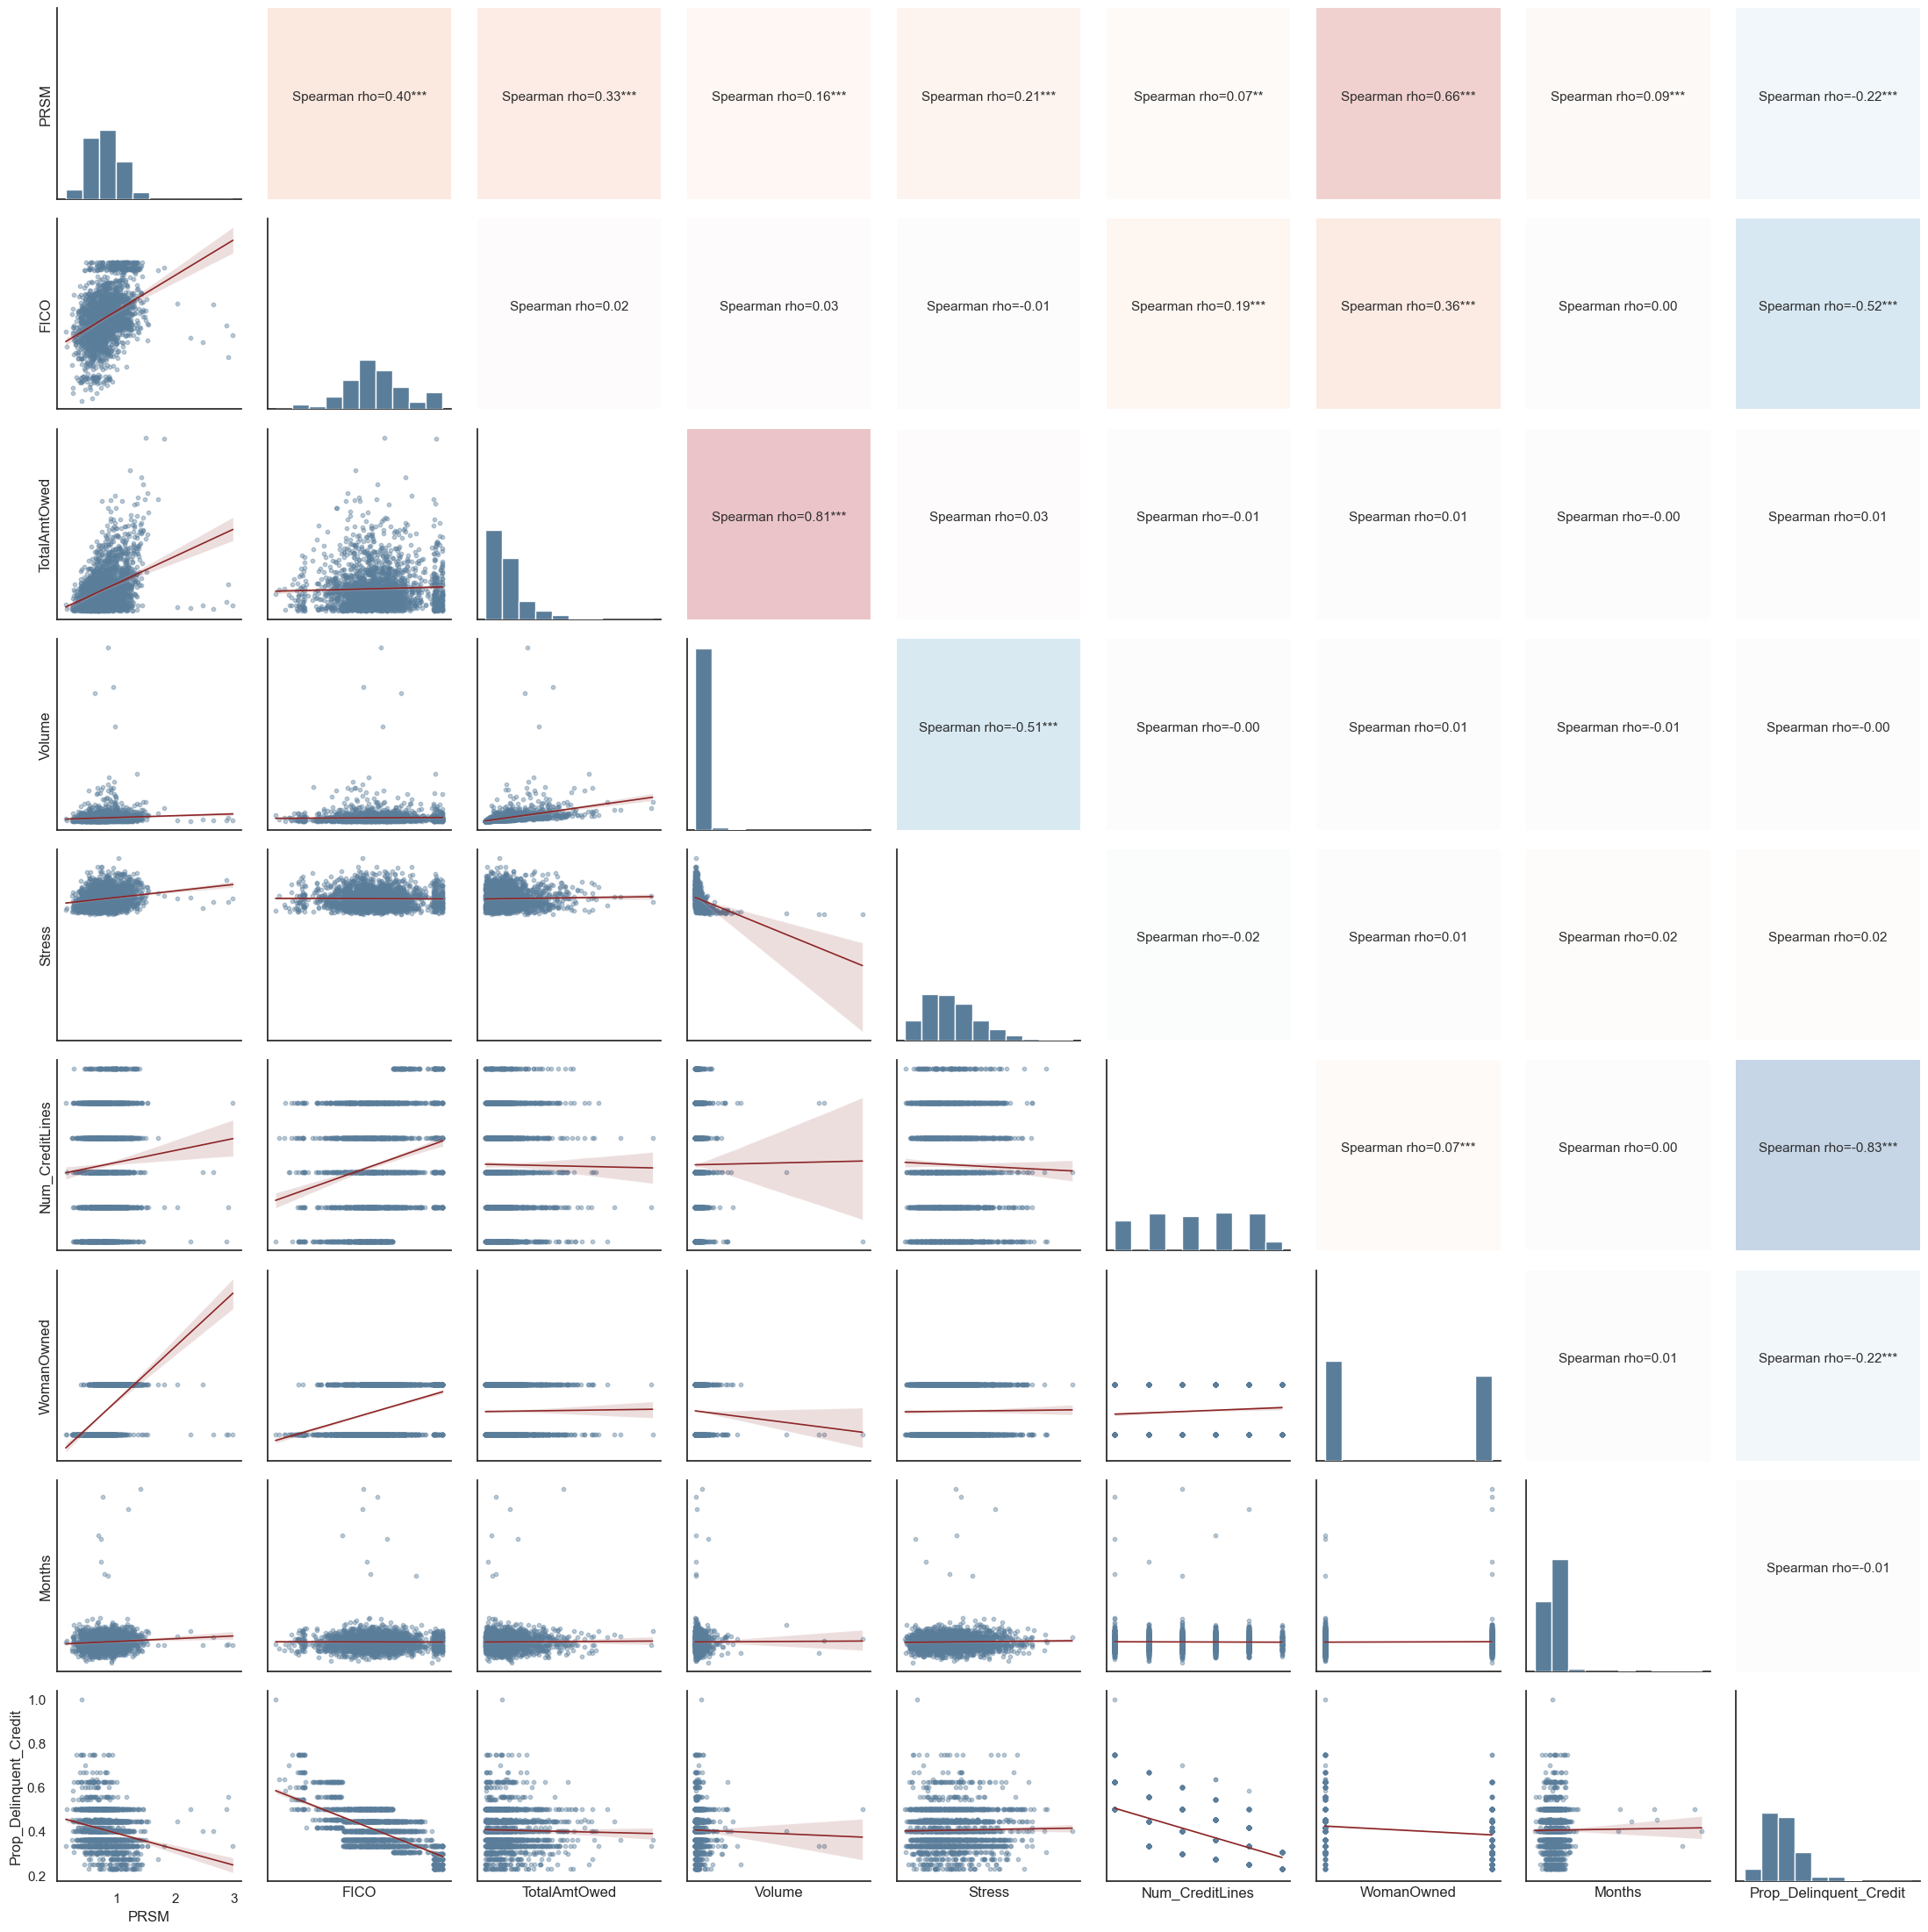

In [ ]:
sns.set_theme(style="white", palette="muted")

def upper_spearman(x, y, **kws):
    ax = plt.gca()
    # Spearman correlation (robust monotonic association)
    r, p = spearmanr(x, y, nan_policy="omit")

    # Background shading by |r|
    # Map r in [-1, 1] -> [0, 1]
    v = 0.5 * (r + 1.0)
    ax.set_facecolor(plt.cm.RdBu_r(v))  # blue=positive, red=negative (muted by alpha below)
    ax.patch.set_alpha(0.25)           # soften the background

    # Text annotation
    stars = "" if np.isnan(p) else ("***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "")
    txt = (
        f"Spearman rho={r:.2f}{stars}\n"
        if not np.isnan(r) else
        "Spearman rho = nan"
    )
    ax.annotate(
        txt, xy=(0.5, 0.5), xycoords=ax.transAxes,
        ha="center", va="center", fontsize=11, color="#2f2f2f"
    )

    # Clean look
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

g = sns.PairGrid(vis_variables)

# Upper: Spearman rho (more useful than duplicated scatter)
g.map_upper(upper_spearman)
# Lower: scatter + linear fit (keep for shape + linearity check)
g.map_lower(
    sns.regplot,
    scatter_kws={'alpha': 0.4, 's': 10, 'color': "#5A7D9A"},
    line_kws={'color': "#8C2525", 'linewidth': 1.2}
)
# Diagonal: univariate distribution
g.map_diag(
    plt.hist,
    bins=10,
    color="#5A7D9A",
    edgecolor='white'
)

plt.show()

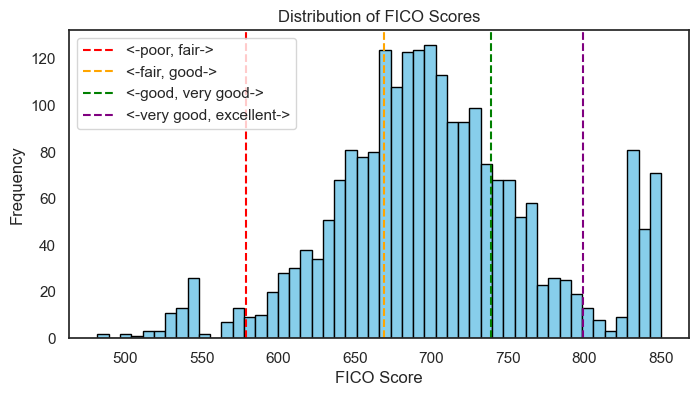

<Figure size 600x300 with 0 Axes>

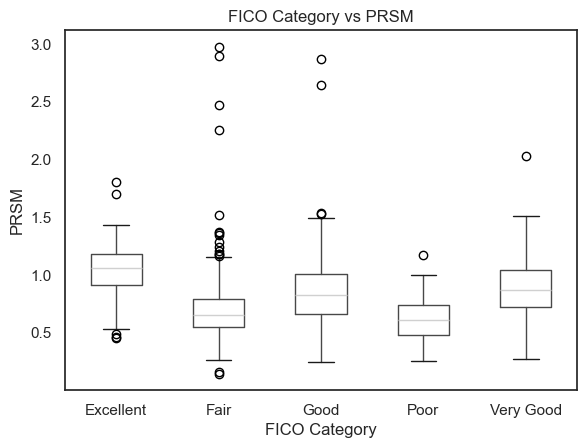

In [10]:
# distribution of FICO scores for different industries and different month
plt.figure(figsize=(8, 4))
plt.hist(data_df['FICO'], bins=50, color='skyblue', edgecolor='black')
# plt lines for different FICO categories
plt.axvline(x=579, color='red', linestyle='--', label='<-poor, fair->')
plt.axvline(x=669, color='orange', linestyle='--', label='<-fair, good->')
plt.axvline(x=739, color='green', linestyle='--', label='<-good, very good->')
plt.axvline(x=799, color='purple', linestyle='--', label='<-very good, excellent->')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.title('Distribution of FICO Scores')
plt.legend()
plt.show()


# Categorize the FICO score (Poor (300\~579), fair(580\~669), good(670\~739), very good(740\~799), excellent(800~850))
def categorize_fico(fico):
    if fico < 580:
        return 'Poor'
    elif fico < 670:
        return 'Fair'
    elif fico < 740:
        return 'Good'
    elif fico < 800:
        return 'Very Good'
    else:
        return 'Excellent'
data_df['FICO_Category'] = data_df['FICO'].apply(categorize_fico)

# FICO category vs PRSM box plot
plt.figure(figsize=(6, 3))
data_df.boxplot(column='PRSM', by='FICO_Category', grid=False)
plt.title('FICO Category vs PRSM')
plt.suptitle('')
plt.xlabel('FICO Category')
plt.ylabel('PRSM')
plt.show()


Next Steps before fitting the model

- Check the plots to get some insights.
  - decide collinearity (could be fatal if we want to do classical regression & want good explanation)
  - decide possible transformation or combination for vars
  - decide deleting vars
- `FICO` is quite special. I am thinking the correlation be like:
  - some vars => `PRSM` (the risk), while also
  - some vars => `FICO` => `PRSM`
  - so `FICO` could be a "mediator", there're lots of this stuff in economics I think, could be helpful for dealing w/ `FICO`!
- Split the dataset into `train` and `dev` by random seeds!